#### what's up mtv?? my name is emily. welcome to my notebook.

#### import essentials

In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from scipy.stats import linregress
import matplotlib.lines as mlines
from matplotlib import cm
from pylab import *
from matplotlib.ticker import ScalarFormatter

#### define atom type

In [2]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)


#### define msd

In [8]:
def msd_from_gsd(gsdfile, start=-30, stop=-1, atom_type='ss', msd_mode = "window"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd) # This is retruning an array of numbers (the y-axis on the msd plot)

#### msds for all temps

In [4]:
def msd_all_temp(state_dict = {"size": "small",
                               "density": 0.8,
                               "process": "quench",
                               "molecule": "PTB7_5mer_smiles"}):
    
    job_list = project.find_jobs(state_dict)

    fig = plt.figure()
    #ax = plt.subplot(111)
    #state_dict['density.$lt'] = 1.3
    color = plt.cm.YlOrBr(np.linspace(0.3, 1, len(job_list)))
    mpl.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

    for kT,job in job_list.groupby('kT_reduced'):
        job = list(job)[0]
        tspf = job.sp['n_steps'] / 100
        msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='all')
        y = msd
        x = range(len(y))
        plt.plot(x, y, label=kT)
        plt.ylim(0, 550)
    for job in job_list:
        if job.sp['molecule'] == "PTB7_5mer_smiles":
            mol = "PTB7 5mer"
        if job.sp['molecule'] == "PTB7_10mer_smiles":
            mol = "PTB7 10mer"
        if job.sp['molecule'] == "PTB7_15mer_smiles":
            mol = "PTB7 15mer"
        if job.sp['molecule'] == "ITIC":
            mol = "ITIC"

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)    
    plt.title("MSD of %s at %sden" % (mol, job.sp['density']), fontsize=10)
    plt.xlabel("Frames", fontsize=10)
    plt.ylabel("MSD", fontsize=10)
    
    plt.show()

#### ptb7

In [6]:
project = signac.get_project("/home/erjank_project/ptb7-project")

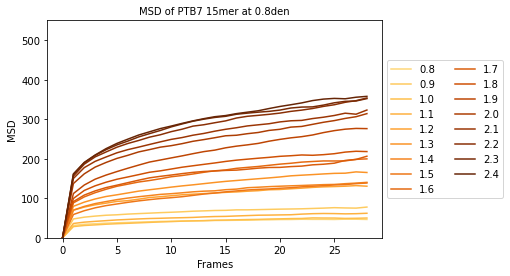

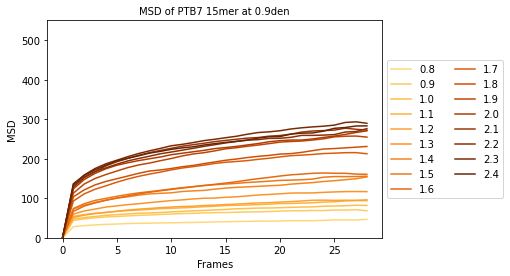

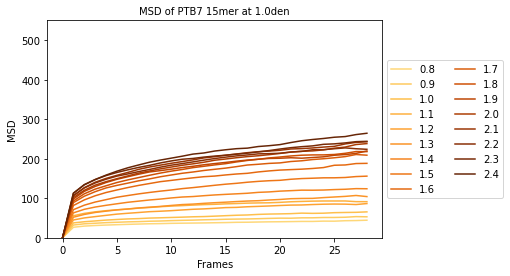

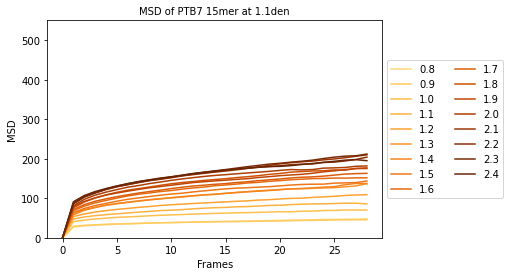

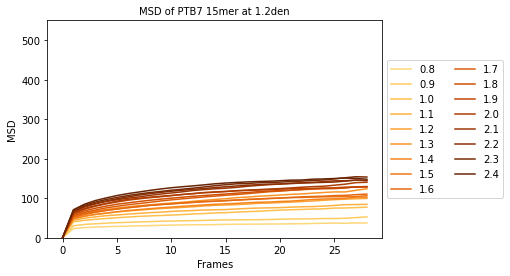

In [9]:
msd_all_temp(state_dict = {"size": "small",
                           "density": 0.8,
                           "process": "quench",
                           "molecule": "PTB7_15mer_smiles"})
msd_all_temp(state_dict = {"size": "small",
                           "density": 0.9,
                           "process": "quench",
                           "molecule": "PTB7_15mer_smiles"})
msd_all_temp(state_dict = {"size": "small",
                           "density": 1.0,
                           "process": "quench",
                           "molecule": "PTB7_15mer_smiles"})
msd_all_temp(state_dict = {"size": "small",
                           "density": 1.1,
                           "process": "quench",
                           "molecule": "PTB7_15mer_smiles"})
msd_all_temp(state_dict = {"size": "small",
                           "density": 1.2,
                           "process": "quench",
                           "molecule": "PTB7_15mer_smiles"})

#### itic

In [10]:
project = signac.get_project("/home/erjank_project/itic-project")

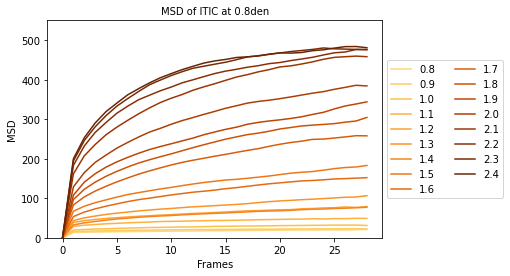

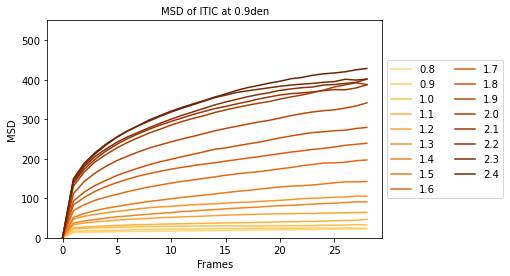

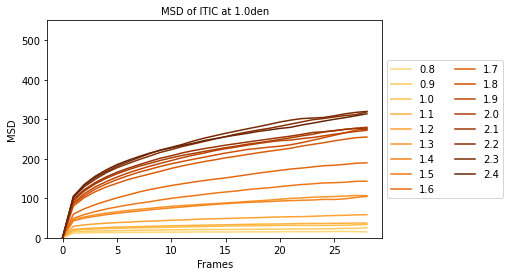

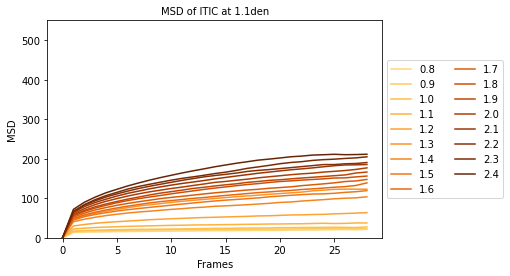

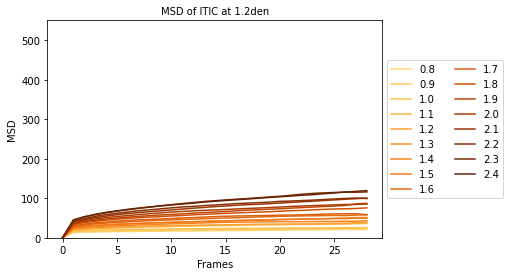

In [11]:
msd_all_temp(state_dict = {"size": "small",
                           "density": 0.8,
                           "process": "quench",
                           "molecule": "ITIC"})
msd_all_temp(state_dict = {"size": "small",
                           "density": 0.9,
                           "process": "quench",
                           "molecule": "ITIC"})
msd_all_temp(state_dict = {"size": "small",
                           "density": 1.0,
                           "process": "quench",
                           "molecule": "ITIC"})
msd_all_temp(state_dict = {"size": "small",
                           "density": 1.1,
                           "process": "quench",
                           "molecule": "ITIC"})
msd_all_temp(state_dict = {"size": "small",
                           "density": 1.2,
                           "process": "quench",
                           "molecule": "ITIC"})

#### msds with slopes

#### function to plot msd vs. timestep with slope (set y axis)

In [9]:
def msd_with_slope(state_dict = {"size": "small",
                                  "density": 0.8,
                                  "process": "quench",
                                  "molecule": "PTB7_5mer_smiles",
                                  "kT_reduced": 0.8}):

    job_list = project.find_jobs(state_dict)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
    mpl.rcParams['axes.prop_cycle'] = plt.cycler('color', color)
    
    for kT,job in job_list.groupby('kT_reduced'):
        job = list(job)[0]
        tspf = job.sp['n_steps'] / 100
        msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='ss')
        y = msd
        x = np.arange(0, len(msd), 1) * tspf
        y2 = msd[-15:]
        x2 = x[-15:]
        plt.plot(x, y, label=job.sp['kT_reduced'], color='#ff9514')
        slope, intercept, r_value, p_value, std_err = linregress(x2, y2)
        plt.plot(x[-15:], x[-15:]*slope + intercept, linestyle = 'dotted', color = '#000000')
        plt.ylim(0, 550)
        
    for job in job_list:
        if job.sp['molecule'] == "PTB7_5mer_smiles":
            mol = "PTB7 5mer"
        if job.sp['molecule'] == "PTB7_10mer_smiles":
            mol = "PTB7 10mer"
        if job.sp['molecule'] == "PTB7_15mer_smiles":
            mol = "PTB7 15mer"
        if job.sp['molecule'] == "ITIC":
            mol = "ITIC"
        
    plt.title("MSD of %s at %sden, %s kT" % (mol, job.sp['density'], job.sp['kT_reduced']), fontsize=10)
    plt.xlabel("Timestep", fontsize=10)
    plt.ylabel("MSD", fontsize=10)

    msdline = mlines.Line2D([], [], color='#ff9514', 
                            linestyle='solid',
                            label='msd of PTB7')
    sline = mlines.Line2D([], [], color='#000000', 
                          linestyle='dotted',
                          label='slope of msd')
    ax.legend(loc='upper left', ncol=1, handles=[msdline, sline])

    print("slope is:")
    print("%10.5e"% slope)

    plt.show()

#### ptb7 (with set y axis)

In [10]:
project = signac.get_project("/home/erjank_project/ptb7-project")

slope is:
9.99345e-08


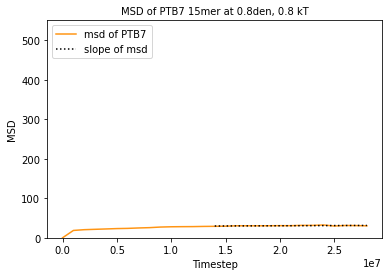

slope is:
1.35444e-05


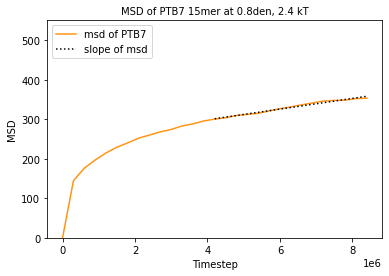

slope is:
2.98749e-07


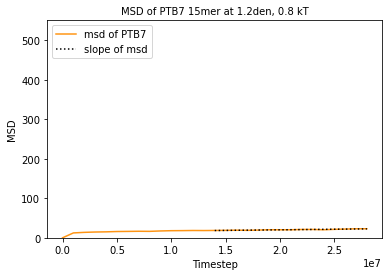

slope is:
2.54714e-06


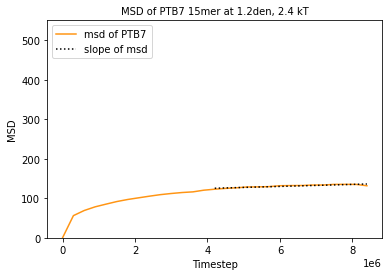

In [13]:
msd_with_slope(state_dict = {"size": "small",
                              "density": 0.8,
                              "process": "quench",
                              "molecule": "PTB7_15mer_smiles",
                              "kT_reduced": 0.8})
msd_with_slope(state_dict = {"size": "small",
                              "density": 0.8,
                              "process": "quench",
                              "molecule": "PTB7_15mer_smiles",
                              "kT_reduced": 2.4})
msd_with_slope(state_dict = {"size": "small",
                              "density": 1.2,
                              "process": "quench",
                              "molecule": "PTB7_15mer_smiles",
                              "kT_reduced": 0.8})
msd_with_slope(state_dict = {"size": "small",
                              "density": 1.2,
                              "process": "quench",
                              "molecule": "PTB7_15mer_smiles",
                              "kT_reduced": 2.4})

#### itic (with set y axis)

In [15]:
project = signac.get_project("/home/erjank_project/itic-project")

slope is:
7.70760e-08


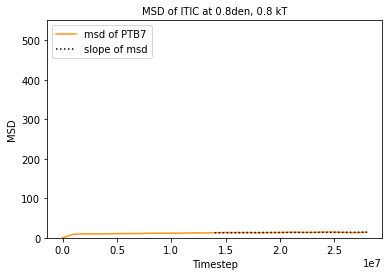

slope is:
9.05023e-06


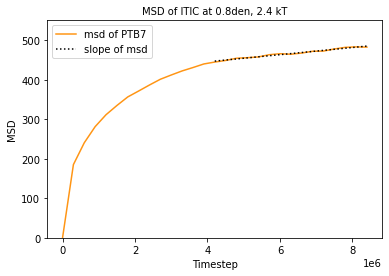

slope is:
1.97854e-07


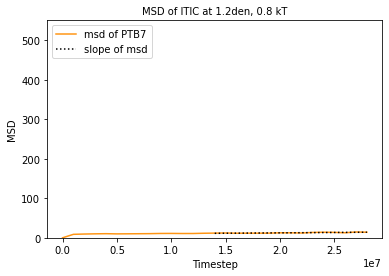

slope is:
7.79775e-06


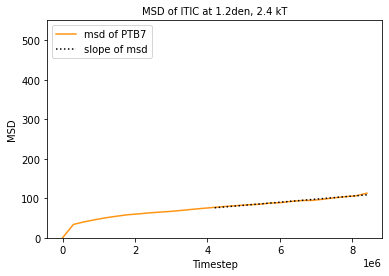

In [16]:
msd_with_slope(state_dict = {"size": "small",
                              "density": 0.8,
                              "process": "quench",
                              "molecule": "ITIC",
                              "kT_reduced": 0.8})
msd_with_slope(state_dict = {"size": "small",
                              "density": 0.8,
                              "process": "quench",
                              "molecule": "ITIC",
                              "kT_reduced": 2.4})
msd_with_slope(state_dict = {"size": "small",
                              "density": 1.2,
                              "process": "quench",
                              "molecule": "ITIC",
                              "kT_reduced": 0.8})
msd_with_slope(state_dict = {"size": "small",
                              "density": 1.2,
                              "process": "quench",
                              "molecule": "ITIC",
                              "kT_reduced": 2.4})

#### ptb7 (no set axis to see slope better)

In [15]:
def msd_slope_nolim(state_dict = {"size": "small",
                                  "density": 0.8,
                                  "process": "quench",
                                  "molecule": "PTB7_5mer_smiles",
                                  "kT_reduced": 0.8}):

    job_list = project.find_jobs(state_dict)
    
    fig = plt.figure()
    color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
    mpl.rcParams['axes.prop_cycle'] = plt.cycler('color', color)
    
    for kT,job in job_list.groupby('kT_reduced'):
        job = list(job)[0]
        tspf = job.sp['n_steps'] / 100
        msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='ss')
        y = msd
        x = np.arange(0, len(msd), 1) * tspf
        y2 = msd[-15:]
        x2 = x[-15:]
        plt.plot(x, y, label=job.sp['kT_reduced'], color='#ff9514')
        slope, intercept, r_value, p_value, std_err = linregress(x2, y2)
        plt.plot(x[-15:], x[-15:]*slope + intercept, linestyle = 'dotted', color = '#000000')
        
    for job in job_list:
        if job.sp['molecule'] == "PTB7_5mer_smiles":
            mol = "PTB7 5mer"
        if job.sp['molecule'] == "PTB7_10mer_smiles":
            mol = "PTB7 10mer"
        if job.sp['molecule'] == "PTB7_15mer_smiles":
            mol = "PTB7 15mer"
        if job.sp['molecule'] == "ITIC":
            mol = "ITIC"
        
    plt.title("MSD of %s at %sden, %s kT" % (mol, job.sp['density'], job.sp['kT_reduced']))
    plt.xlabel("Timestep", fontsize=10)
    plt.ylabel("MSD", fontsize=10)

    msdline = mlines.Line2D([], [], color='#ff9514', 
                            linestyle='solid',
                            label='msd of PTB7')
    sline = mlines.Line2D([], [], color='#000000', 
                          linestyle='dotted',
                          label='slope of msd')
    plt.legend(loc='upper left', ncol=1, handles=[msdline, sline])

    print("slope is:")
    print("%10.5e"% slope)

    plt.show()

#### ptb7 slope example

In [16]:
project = signac.get_project("/home/erjank_project/ptb7-project")

slope is:
1.89177e-05


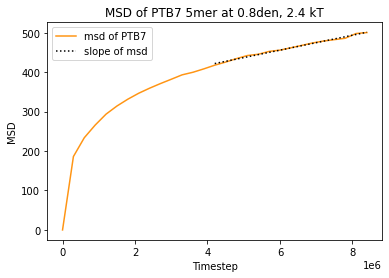

slope is:
5.90287e-06


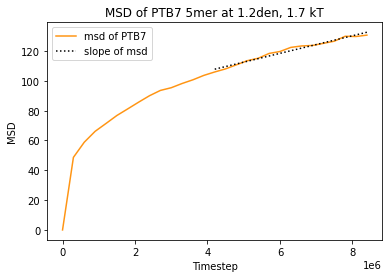

In [17]:
msd_slope_nolim(state_dict = {"size": "small",
                              "density": 0.8,
                              "process": "quench",
                              "molecule": "PTB7_5mer_smiles",
                              "kT_reduced": 2.4})
msd_slope_nolim(state_dict = {"size": "small",
                              "density": 1.2,
                              "process": "quench",
                              "molecule": "PTB7_5mer_smiles",
                              "kT_reduced": 1.7})

#### iticcc slope example

In [18]:
project = signac.get_project("/home/erjank_project/itic-project")

slope is:
9.05023e-06


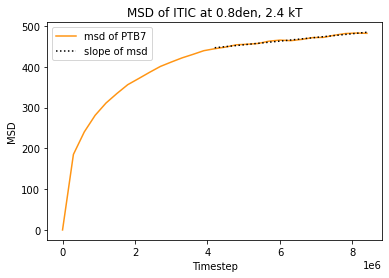

slope is:
-9.14012e-08


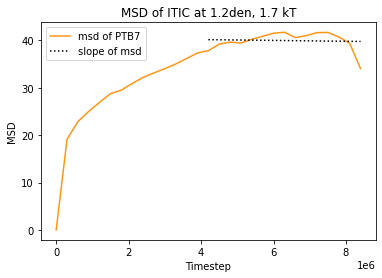

In [20]:
msd_slope_nolim(state_dict = {"size": "small",
                              "density": 0.8,
                              "process": "quench",
                              "molecule": "ITIC",
                              "kT_reduced": 2.4})
msd_slope_nolim(state_dict = {"size": "small",
                              "density": 1.2,
                              "process": "quench",
                              "molecule": "ITIC",
                              "kT_reduced": 1.7})

#### slopes of msd vs temp plots

In [21]:
def slope_vs_temp(state_dict = {"size": "small",
                                "density": 0.9,
                                "process": "quench",
                                "molecule": "PTB7_5mer_smiles",
                                "kT_reduced": 0.9}):
    
    job_list = project.find_jobs(state_dict)
    
    fig = plt.figure()
    #ax = plt.subplot(111)
    state_dict['kT_reduced.$lt'] = 2.5
    color = plt.cm.YlOrBr(np.linspace(0.4, 1, len(job_list)))

    mpl.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

    for temp,job in job_list.groupby('kT_reduced'):
        job = list(job)[0]
        msd = msd_from_gsd(job.fn('trajectory.gsd'))
        slope = job.doc['msd_slope']
        x2=job.sp["kT_reduced"]
        y2=slope
        plt.ylim(-0.000005, 0.000025)
        plt.scatter(x2,y2, label=temp)
        plt.minorticks_on()
        plt.tick_params(axis='both', which='both', direction='in', labelsize=10)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    #for job in job_list:
        if job.sp['molecule'] == "ITIC":
            mol = "ITIC"
        if job.sp['molecule'] == "PTB7_5mer_smiles":
            mol = "PTB7 5mer"
        if job.sp['molecule'] == "PTB7_10mer_smiles":
            mol = "PTB7 10mer"
        if job.sp['molecule'] == "PTB7_15mer_smiles":
            mol = "PTB7 15mer"
        
        plt.title("Slope vs. Temp of %s at %s density" % (mol, job.sp['density']), fontsize=10)
    plt.axhline(y=0, color='#d1b799', linestyle='dotted')
    plt.xlabel("Temperature(kT)", fontsize=10)
    plt.ylabel("Slope", fontsize=10)
    plt.show()
    

#### ptb7

In [23]:
project = signac.get_project("/home/erjank_project/ptb7-project")

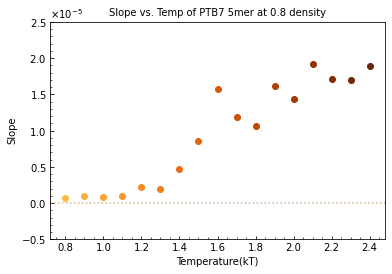

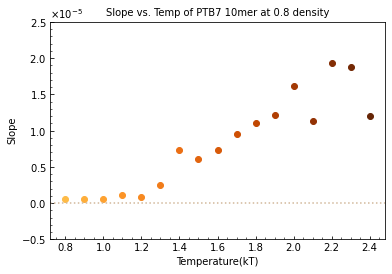

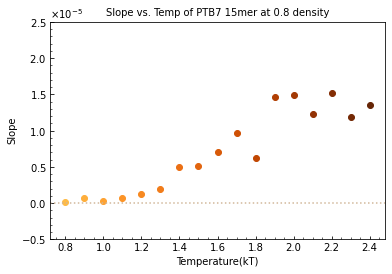

In [24]:
slope_vs_temp(state_dict = {"size": "small",
                            "density": 0.8,
                            "process": "quench",
                            "molecule": "PTB7_5mer_smiles"})
slope_vs_temp(state_dict = {"size": "small",
                            "density": 0.8,
                            "process": "quench",
                            "molecule": "PTB7_10mer_smiles"})
slope_vs_temp(state_dict = {"size": "small",
                            "density": 0.8,
                            "process": "quench",
                            "molecule": "PTB7_15mer_smiles"})

#### itic

In [29]:
project = signac.get_project("/home/erjank_project/itic-project")

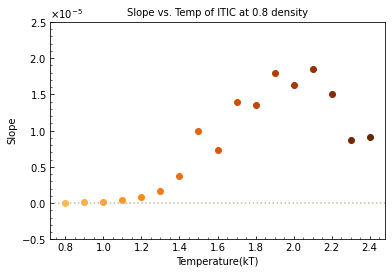

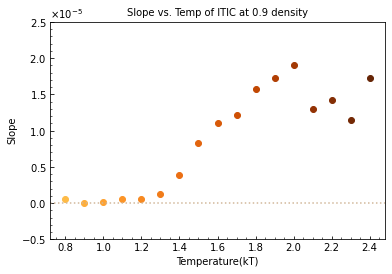

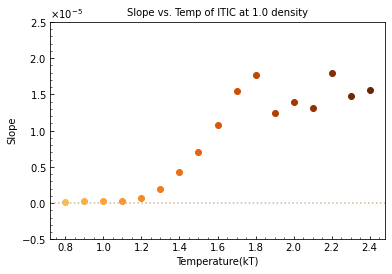

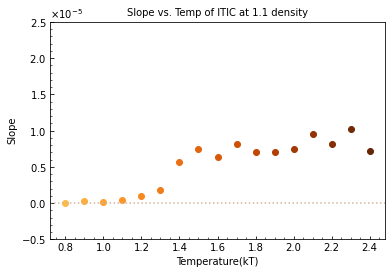

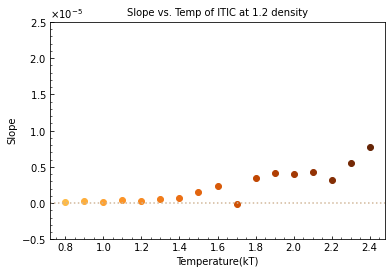

In [30]:
slope_vs_temp(state_dict = {"size": "small",
                            "density": 0.8,
                            "process": "quench",
                            "molecule": "ITIC"})
slope_vs_temp(state_dict = {"size": "small",
                            "density": 0.9,
                            "process": "quench",
                            "molecule": "ITIC"})
slope_vs_temp(state_dict = {"size": "small",
                            "density": 1.0,
                            "process": "quench",
                            "molecule": "ITIC"})
slope_vs_temp(state_dict = {"size": "small",
                            "density": 1.1,
                            "process": "quench",
                            "molecule": "ITIC"})
slope_vs_temp(state_dict = {"size": "small",
                            "density": 1.2,
                            "process": "quench",
                            "molecule": "ITIC"})

#### msd slopes vs. temp for all lengths on one

In [47]:
def slope_and_lengths(state_dict = {"size": "small",
                                    "process": "quench",
                                    "density": 0.8}):
    
    project = signac.get_project("/home/erjank_project/ptb7-project")
    
    job_list = project.find_jobs(state_dict)

    fig = plt.figure()
    ax = plt.subplot(111)

    for temp,job in enumerate(job_list):

        msd = msd_from_gsd(job.fn('trajectory.gsd'))
        slope = job.doc['msd_slope']
        x2=job.sp["kT_reduced"]
        y2=slope
        mark = "x"
        if job.sp["molecule"] == 'PTB7_5mer_smiles':
            mark = "x"
            colo = ['#000000']
        if job.sp["molecule"] == 'PTB7_10mer_smiles':
            mark = "v"
            colo = ['#f59b1d']
        if job.sp["molecule"] == 'PTB7_15mer_smiles':
            mark = "o"
            colo = ['#9e2828']
        plt.scatter(x2,y2, label=temp, marker=mark, color = colo)#, marker=mpl.markers)
        plt.minorticks_on()
        plt.tick_params(axis='both', which='both', direction='in')
        plt.ylim(-0.000005, 0.000025)
        
        
        #changing project and job lists for itic
        project = signac.get_project("/home/erjank_project/itic-project")
        job_list = project.find_jobs(state_dict)


        for temp,job in enumerate(job_list):

            msd = msd_from_gsd(job.fn('trajectory.gsd'))
            slope = job.doc['msd_slope']
            x2=job.sp["kT_reduced"]
            y2=slope
            mark = "x"
            if job.sp["molecule"] == 'ITIC':
                mark = "d"
                colo = ['#c2b4a5']
            plt.scatter(x2,y2, label=temp, marker=mark, color = colo)#, marker=mpl.markers)
            plt.minorticks_on()
            plt.tick_params(axis='both', which='both', direction='in')
            plt.ylim(-0.000005, 0.000025)
        plt.title('Slope vs. Temp of %s density' % (job.sp['density']), fontsize=10)
        plt.xlabel('Temperature (kT)', fontsize=10)
        plt.ylabel('Slope', fontsize=10)

    

    mer_5 = mlines.Line2D([], [], color='#000000', marker='x', linestyle='None',
                          label='PTB7 5mer')
    mer_10 = mlines.Line2D([], [], color='#f59b1d', marker='v', linestyle='None',
                           label='PTB7 10mer')
    mer_15 = mlines.Line2D([], [], color='#9e2828', marker='o', linestyle='None',
                           label='PTB7 15mer')
    itic = mlines.Line2D([], [], color='#c2b4a5', marker='d', linestyle='None',
                           label='ITIC')

    plt.legend(handles=[mer_5, mer_10, mer_15, itic], loc="upper left")

    plt.show()


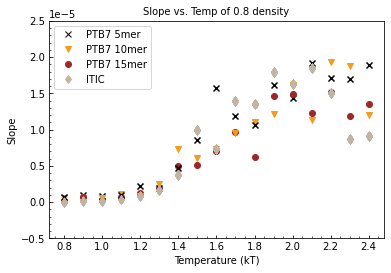

In [49]:
slope_and_lengths(state_dict = {"size": "small",
                                "process": "quench",
                                "density": 0.8})

#### ptb7

#### felt cute, my delete later idk
but actually it just plots PTB7 lengths, not ITIC

In [39]:
project = signac.get_project("/home/erjank_project/ptb7-project")

In [31]:
def slope_and_lengths(state_dict = {"size": "small",
                                    "process": "quench",
                                    "density": 0.8}):

    job_list = project.find_jobs(state_dict)

    fig = plt.figure()
    ax = plt.subplot(111)
    #state_dict['kT_reduced.$lt'] = 2.5
    #color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))

    for temp,job in enumerate(job_list):

        msd = msd_from_gsd(job.fn('trajectory.gsd'))
        slope = job.doc['msd_slope']
        x2=job.sp["kT_reduced"]
        y2=slope
        mark = "x"
        if job.sp["molecule"] == 'PTB7_5mer_smiles':
            mark = "x"
            colo = ['#000000']
        if job.sp["molecule"] == 'PTB7_10mer_smiles':
            mark = "v"
            colo = ['#f59b1d']
        if job.sp["molecule"] == 'PTB7_15mer_smiles':
            mark = "o"
            colo = ['#9e2828']
        plt.scatter(x2,y2, label=temp, marker=mark, color = colo)#, marker=mpl.markers)
        plt.minorticks_on()
        plt.tick_params(axis='both', which='both', direction='in')
        plt.ylim(-0.000005, 0.000025)
    plt.title('Slope vs. Temp of %s density' % (job.sp['density']), fontsize=10)
    plt.xlabel('Temperature (kT)', fontsize=10)
    plt.ylabel('Slope', fontsize=10)

    mer_5 = mlines.Line2D([], [], color='#000000', marker='x', linestyle='None',
                          label='5mer')
    mer_10 = mlines.Line2D([], [], color='#f59b1d', marker='v', linestyle='None',
                           label='10mer')
    mer_15 = mlines.Line2D([], [], color='#9e2828', marker='o', linestyle='None',
                           label='15mer')

    plt.legend(handles=[mer_5, mer_10, mer_15], loc="upper left")

    plt.show()


